# Draft 1 - Figure 5

__Histograms!__

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 4 as well.

### Load functions and packages

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, gridspec,
    mpl,copy
    )

from functions import to_png

import regionmask

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=1960+obs_trends.duration.max(),np.nan) # Mask the unemerged regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [4]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

In [5]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [6]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [7]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [8]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
gistemp_2x2_dir = 'GISTEMP_2x2/'
gistemp_2x2_5x5_dir = 'GISTEMP_2x2/20240217_5x5remap'
hadcrut5_dir    = 'HadCRUT5/'
obsle_dir       = 'mckinnon_OLENS/'

In [9]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [10]:
# gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_2x2_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_2x2_5x5_dir))
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [11]:
# gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_2x2_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_2x2_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load the trend data

In [12]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_2x2_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'record': -1})
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat','realization':'record'})['tas'].chunk({'record': -1})
gistemp_5x5_spatial_trends_all['record'] = gistemp_5x5_spatial_trends_all['record'] - 2 # Shift back to 1
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath)

In [13]:
gistemp_regional_trends_all  = xr.open_dataarray(*gistemp_2x2_regional_trends_filepath).sel(startyear=1960).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1960).drop('startyear').rename({'realization':'record'})
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load obs-le percentile data

### Compute TTE generally

In [14]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_all,
                           'HadCRUT':hadcrut5_spatial_trends_all}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [15]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(obs_trends=_obs_trends.median(dim='record'),
                                    pic_trends=_model_trends.sel(percentile=97.5))

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(obs_trends=_obs_trends,
                                      pic_trends=_model_trends.sel(percentile=97.5))

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='record',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


OBS-LE
HadCRUT
CESM1
MPI
CanESM2


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


OBS-LE
HadCRUT
CESM1
MPI
CanESM2


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


ESM2M
OBS-LE
CPU times: user 7.7 s, sys: 1.51 s, total: 9.21 s
Wall time: 13.6 s


/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(
/glade/work/jonahshaw/miniconda3/envs/pangeo/lib/python3.11/site-packages/xarray/core/dataset.py:8026: FutureWarning: The `interpolation` argument to quantile was renamed to `method`.
  warnings.warn(


### Plot with IPCC Regions

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [16]:
%%time

# User set-up
data  = regional_box[0]

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

# ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
for i in ipcc_ar6_regions_all.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset

CPU times: user 2.03 s, sys: 100 ms, total: 2.13 s
Wall time: 4.36 s


### Plot histograms for regional and spatial data

Show how the resolution may influence the ToE and delay using histograms.

#### Create Combined Histogram Figure

Regional Mean fraction emerge: 0.959
Regional Strict fraction emerge: 0.897
5x5 deg. Mean fraction emerge: 0.842
5x5 deg. Strict fraction emerge: 0.750
Regional fraction delay >5years: 0.243
Regional fraction delay >15years: 0.069
5x5 deg. fraction delay >5years: 0.384
5x5 deg. fraction delay >15years: 0.100


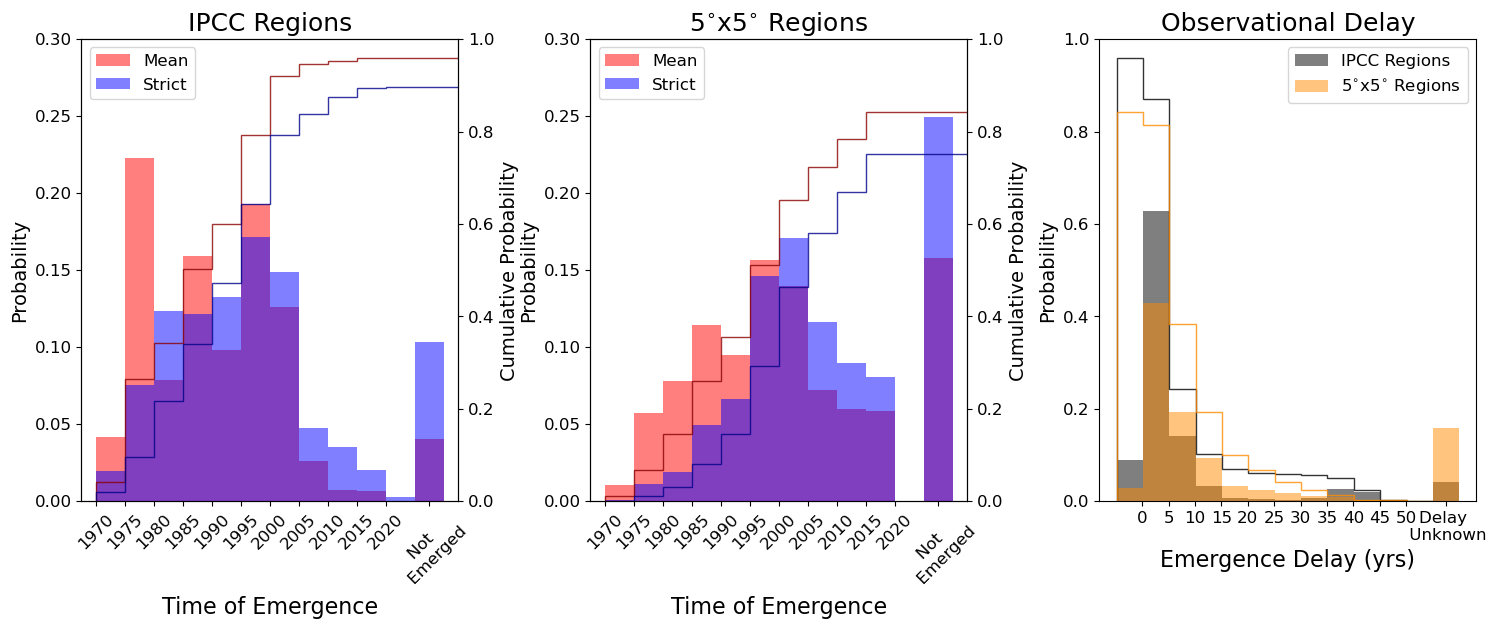

In [17]:
# Go model agnostic

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon','model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,nan_mask_value2+5,5)
xticks = np.arange(1970,nan_mask_value2+5,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,2041,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=True,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)

bins = np.arange(-4.9,61,5)
reverse_bins = np.arange(-4.9,56,5)

xticks = list(np.arange(0,51,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('Delay \n Unknown')
# xticklabels.append('No Mean \n Emergence')
yticks = np.arange(0,0.14,0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=bins,
                           color='black',alpha=0.5,
                           label='IPCC Regions',
                           density=False,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )


_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='black',alpha=0.8,
                          # label='Regional (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >15years: %.3f' % _n[4])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=bins,
                           color='darkorange',alpha=0.5,
                           label='$5^{\circ}$x$5^{\circ}$ Regions',
                           density=False,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='darkorange',alpha=0.8,
                        # label='Spatial (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [18]:
to_png(file=fig,filename='ToE_histogram_statistics2',dpi=300,ext='pdf',bbox_inches='tight')

Separate by model and obs.

#### Select just CESM1 and GISTEMP (for AGU)

Regional Mean fraction emerge: 0.899
Regional Strict fraction emerge: 0.853
5x5 deg. Mean fraction emerge: 0.841
5x5 deg. Strict fraction emerge: 0.740
Regional fraction delay >5years: 0.180
Regional fraction delay >15years: 0.053
5x5 deg. fraction delay >5years: 0.301
5x5 deg. fraction delay >15years: 0.092


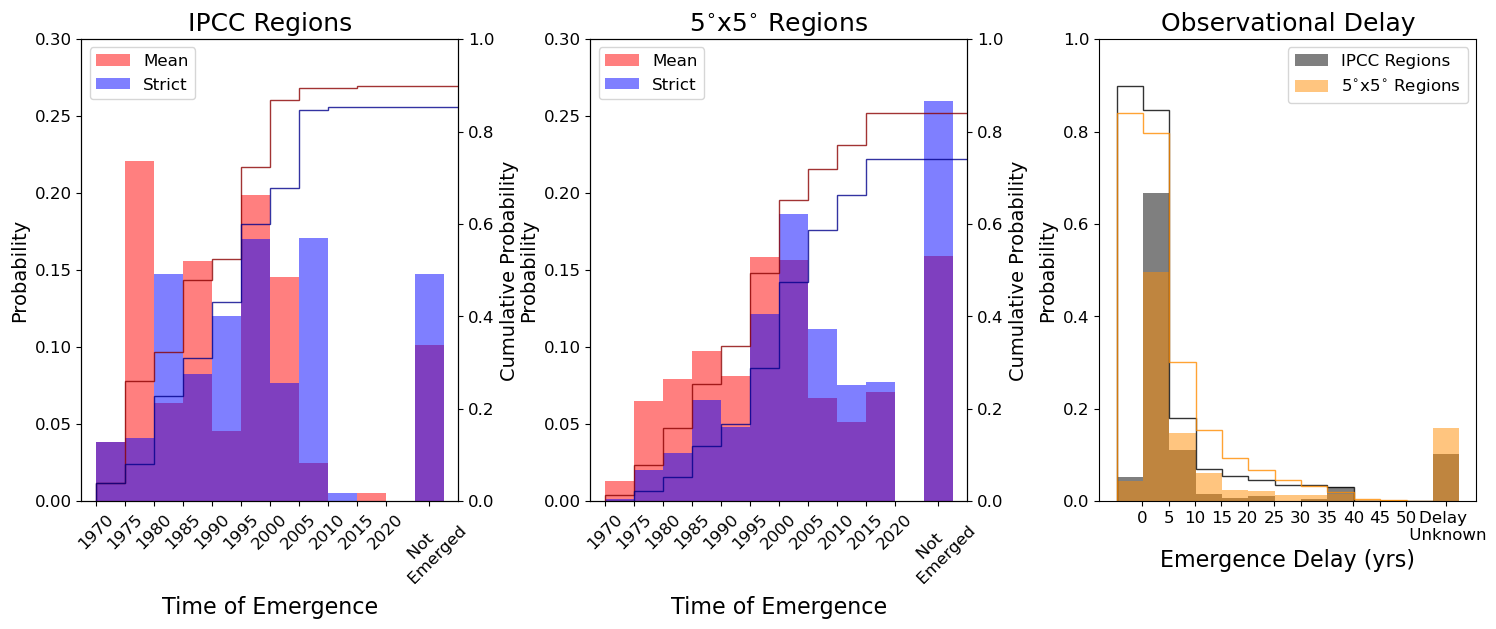

In [19]:
# Go model agnostic
_model = 'CESM1'
_obs   = 'GISTEMP_5x5'

regional_data = regional_box[0].sel(model=_model,obs=_obs) # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da.sel(model=_model,obs=_obs)
spatial_data  = spatial_masked_da.sel(model=_model,obs=_obs)

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon',)#'model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,nan_mask_value2+5,5)
xticks = np.arange(1970,nan_mask_value2+5,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,2041,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=True,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)

bins = np.arange(-4.9,61,5)
reverse_bins = np.arange(-4.9,56,5)

xticks = list(np.arange(0,51,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('Delay \n Unknown')
# xticklabels.append('No Mean \n Emergence')
yticks = np.arange(0,0.14,0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=bins,
                           color='black',alpha=0.5,
                           label='IPCC Regions',
                           density=False,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )


_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='black',alpha=0.8,
                          # label='Regional (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >15years: %.3f' % _n[4])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=bins,
                           color='darkorange',alpha=0.5,
                           label='$5^{\circ}$x$5^{\circ}$ Regions',
                           density=False,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='darkorange',alpha=0.8,
                        # label='Spatial (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [20]:
to_png(file=fig,filename='ToE_histogram_statistics2_CESM1_GISTEMP',dpi=300,ext='pdf',bbox_inches='tight')

#### Mask by surface type

Just select land/ocean regions.

How to do for the spatial data? Interp like the IPCC data and then proceed?

#### Histograms for land-only

Regional Mean fraction emerge: 0.981
Regional Strict fraction emerge: 0.938
Spatial Mean fraction emerge: 0.927
Spatial Strict fraction emerge: 0.818
Regional fraction delay >5years: 0.257
Regional fraction delay >15years: 0.058
Spatial fraction delay >5years: 0.374
Spatial fraction delay >15years: 0.083


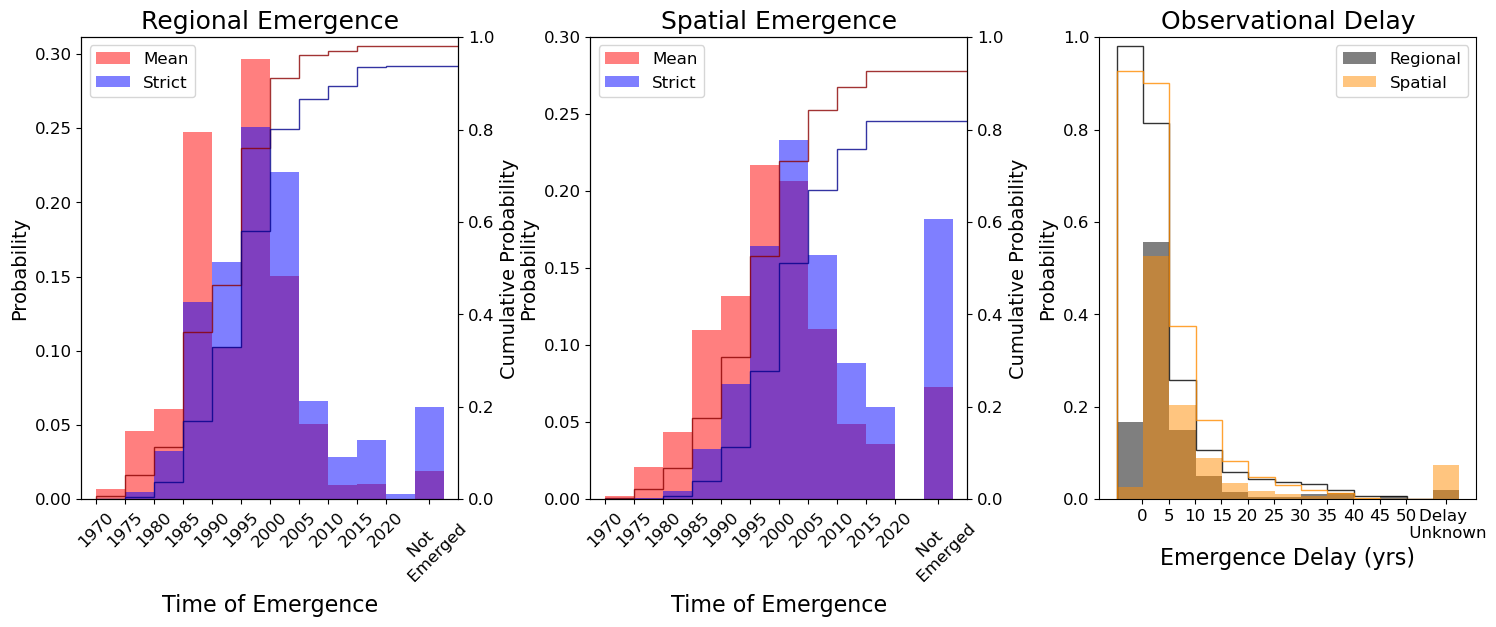

In [21]:
# Go model agnostic
regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = land #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

# Start plot 1
ax = axs[0]
data = regional_data_latloned

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,nan_mask_value2+5,5)
xticks = np.arange(1970,nan_mask_value2+5,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# Need to stack for weighting and masking
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs')).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs')).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)
# ax.set_ylim(0,1.0)

ax.set_title('Regional Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,2041,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=True,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Spatial Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs'))

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Spatial Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('Spatial Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)

bins = np.arange(-4.9,61,5)
reverse_bins = np.arange(-4.9,56,5)

xticks = list(np.arange(0,51,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('Delay \n Unknown')
# xticklabels.append('No Mean \n Emergence')
yticks = np.arange(0,0.14,0.01)

data = regional_data_subset
regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(data.lat)),data)
regional_data_weights_stack = regional_data_weights.stack(z=('lat','lon','model','obs'))
regional_data_subset_stack  = data.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=bins,
                           color='black',alpha=0.5,
                           label='Regional',
                           density=False,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )


_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='black',alpha=0.8,
                          # label='Regional (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >15years: %.3f' % _n[4])

data = spatial_data_subset
spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(data.lat)),data)
spatial_data_weights_stack = spatial_data_weights.stack(z=('lat','lon','model','obs'))
spatial_data_subset_stack  = data.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=bins,
                           color='darkorange',alpha=0.5,label='Spatial',
                           density=False,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='darkorange',alpha=0.8,
                        # label='Spatial (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

print('Spatial fraction delay >5years: %.3f' % _n[2])
print('Spatial fraction delay >15years: %.3f' % _n[4])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [22]:
to_png(file=fig,filename='ToE_histogram_statistics2_land',dpi=300,ext='pdf',bbox_inches='tight')

#### Histograms for ocean-only

Regional Mean fraction emerge: 0.951
Regional Strict fraction emerge: 0.880
Spatial Mean fraction emerge: 0.806
Spatial Strict fraction emerge: 0.723
Regional fraction delay >5years: 0.238
Regional fraction delay >15years: 0.073
Spatial fraction delay >5years: 0.389
Spatial fraction delay >15years: 0.107


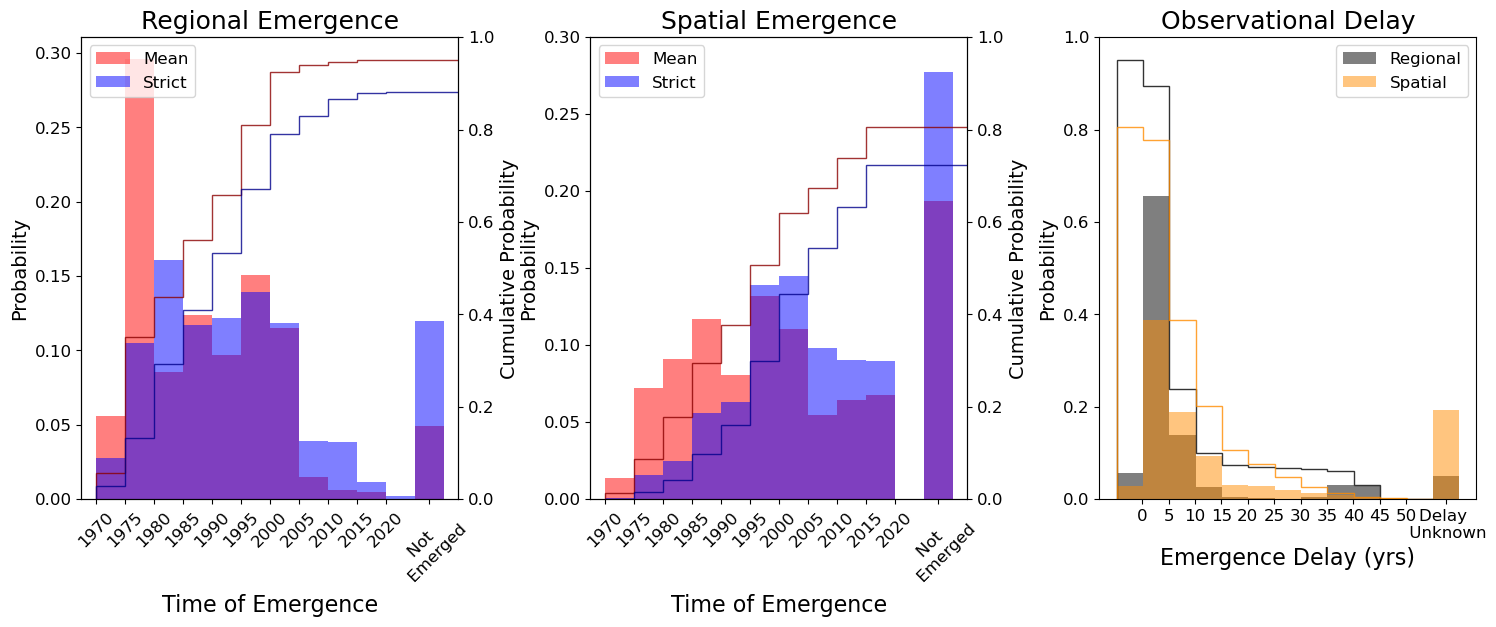

In [23]:
# Go model agnostic
regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = ocean #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

# Start plot 1
ax = axs[0]
data = regional_data_latloned

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,nan_mask_value2+5,5)
xticks = np.arange(1970,nan_mask_value2+5,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# Need to stack for weighting and masking
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs')).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs')).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)
# ax.set_ylim(0,1.0)

ax.set_title('Regional Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(1970.01,2041,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

_n,_bins,_pathes = ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=True,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Spatial Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs'))

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

_n,_bins,_pathes = ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

print('Spatial Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('Spatial Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)

bins = np.arange(-4.9,61,5)
reverse_bins = np.arange(-4.9,56,5)

xticks = list(np.arange(0,51,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('Delay \n Unknown')
# xticklabels.append('No Mean \n Emergence')
yticks = np.arange(0,0.14,0.01)

data = regional_data_subset
regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(data.lat)),data)
regional_data_weights_stack = regional_data_weights.stack(z=('lat','lon','model','obs'))
regional_data_subset_stack  = data.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=bins,
                           color='black',alpha=0.5,
                           label='Regional',
                           density=False,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )


_n,_bins,_pathes = ax.hist(x=regional_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='black',alpha=0.8,
                          # label='Regional (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
                          )

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >15years: %.3f' % _n[4])

data = spatial_data_subset
spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(data.lat)),data)
spatial_data_weights_stack = spatial_data_weights.stack(z=('lat','lon','model','obs'))
spatial_data_subset_stack  = data.stack(z=('lat','lon','model','obs'))

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=bins,
                           color='darkorange',alpha=0.5,label='Spatial',
                           density=False,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

_n,_bins,_pathes = ax.hist(x=spatial_data_subset_stack,
                           bins=reverse_bins,
                           histtype="step",
                           color='darkorange',alpha=0.8,
                        # label='Spatial (reverse cumulative)',
                           density=False,
                           cumulative=-1,
                           weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
                          )

print('Spatial fraction delay >5years: %.3f' % _n[2])
print('Spatial fraction delay >15years: %.3f' % _n[4])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [24]:
to_png(file=fig,filename='ToE_histogram_statistics2_ocean',dpi=300,ext='pdf',bbox_inches='tight')

__Woohoo! I did it! This was a lot of code to write.__

### Older Code

##### Old masking code. May still be useful later

Land-only

In [19]:
%%time

# User set-up
data  = regional_box[0]
offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

ipcc_ar6_regions_land  = regionmask.defined_regions.ar6.land

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

unc_mask = xr.where(np.isnan(unc_mask),offset,unc_mask) # Mask the not land regions.

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_land.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)
    
regional_land_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset        

CPU times: user 1.51 s, sys: 85.6 ms, total: 1.6 s
Wall time: 2.11 s


Ocean-only

In [20]:
%%time

# User set-up
data  = regional_box[0]
offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

ipcc_ar6_regions_ocean  = regionmask.defined_regions.ar6.ocean

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

unc_mask = xr.where(np.isnan(unc_mask),offset,unc_mask) # Mask the not land regions.

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_ocean.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)
    
regional_ocean_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset        

CPU times: user 540 ms, sys: 87.1 ms, total: 627 ms
Wall time: 764 ms


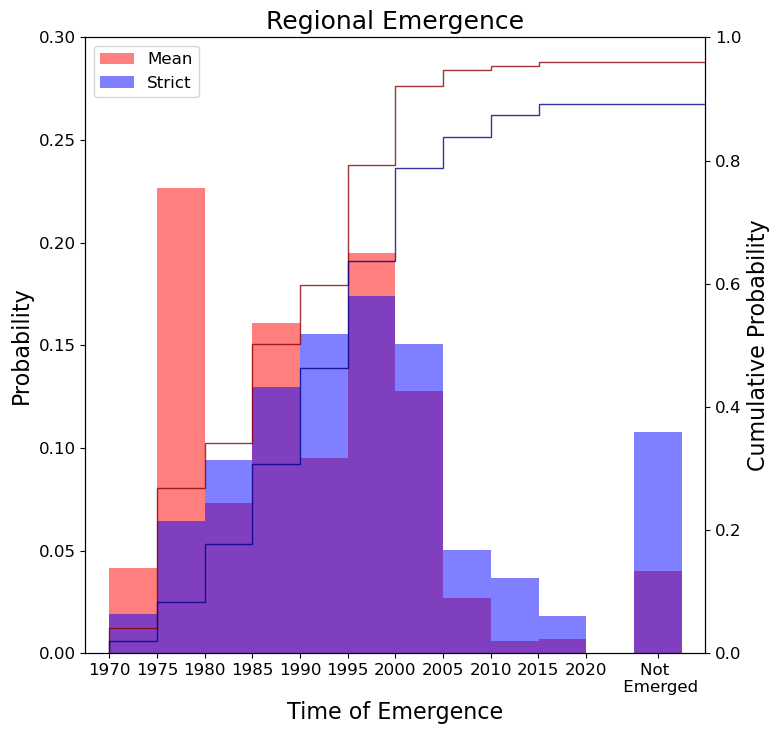

In [ ]:
# Go model agnostic
regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

data = regional_data_latloned

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

fig,ax = plt.subplots(1,1,figsize=(8,8))

ax2 = ax.twinx()

bins = np.arange(1970.01,nan_mask_value2+5,5)
xticks = np.arange(1970,nan_mask_value2+5,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs')).values

ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs')).values

ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=16)

ax.set_title('Regional Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=16)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


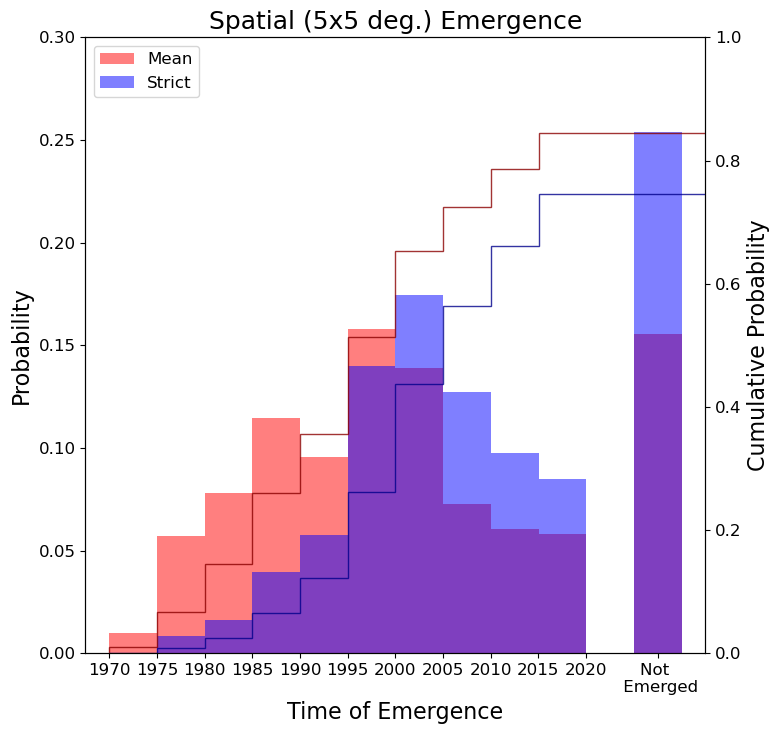

In [ ]:
# Go model agnostic
regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

fig,ax = plt.subplots(1,1,figsize=(8,8))

ax2 = ax.twinx()

bins = np.arange(1970.01,2041,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0,0.31,0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack  = mean_data_subset.stack(z=('lat','lon','model','obs'))
mean_data_subset_stack2 = mean_data_subset2.stack(z=('lat','lon','model','obs'))

ax.hist(x=mean_data_subset_stack,
        bins=bins,
        color='red',alpha=0.5,label='Mean',
        density=False,
        weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
       )

ax2.hist(x=mean_data_subset_stack2,
         bins=bins,
         color='darkred',alpha=0.8,label='Mean ToE Cumulative',
         density=True,
         weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack  = strict_data_subset.stack(z=('lat','lon','model','obs'))
strict_data_subset_stack2 = strict_data_subset2.stack(z=('lat','lon','model','obs'))

ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
        )

ax2.hist(x=strict_data_subset_stack2,
         bins=bins,
         color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
         density=False,
         weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
         histtype="step",        
         cumulative=True
        )

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=16)

ax.set_title('Spatial (5x5 deg.) Emergence',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=16)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))


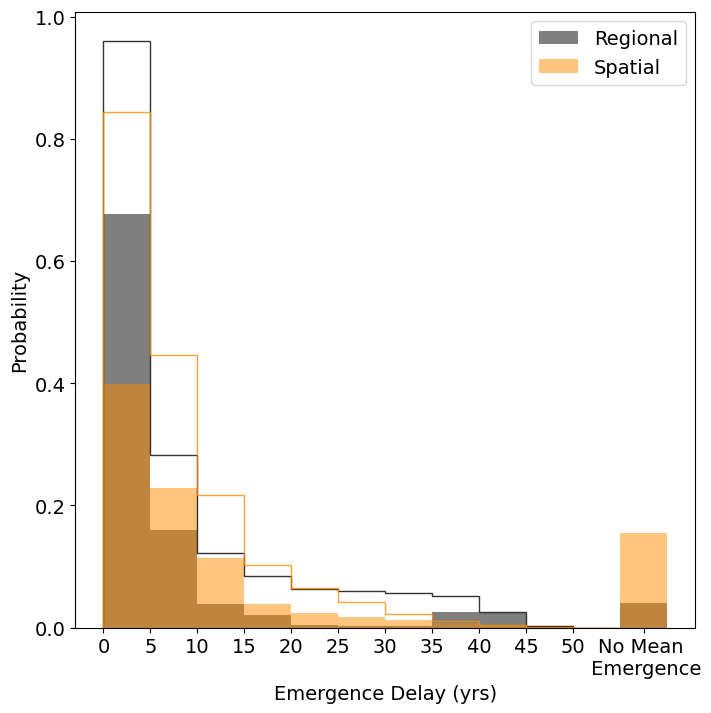

In [30]:
# Go model agnostic
metric = 'delay' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(8,8))

bins = np.arange(0,61,5)
reverse_bins = np.arange(0,56,5)

xticks = list(np.arange(0,51,5))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('No Mean \n Emergence')
yticks = np.arange(0,0.14,0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=('lat','lon','model','obs'))
regional_data_subset_stack  = regional_data_subset.stack(z=('lat','lon','model','obs'))

ax.hist(x=regional_data_subset_stack,
        bins=bins,
        color='black',alpha=0.5,
        label='Regional',
        density=False,
        weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
       )


ax.hist(x=regional_data_subset_stack,
        bins=reverse_bins,
        histtype="step",
        color='black',alpha=0.8,
        # label='Regional (reverse cumulative)',
        density=False,
        cumulative=-1,
        weights=regional_data_weights_stack/regional_data_weights_stack.sum(),
       )

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=('lat','lon','model','obs'))
spatial_data_subset_stack  = spatial_data_subset.stack(z=('lat','lon','model','obs'))

ax.hist(x=spatial_data_subset_stack,
        bins=bins,
        color='darkorange',alpha=0.5,label='Spatial',
        density=False,
        weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
       )

ax.hist(x=spatial_data_subset_stack,
        bins=reverse_bins,
        histtype="step",
        color='darkorange',alpha=0.8,
        # label='Spatial (reverse cumulative)',
        density=False,
        cumulative=-1,
        weights=spatial_data_weights_stack/spatial_data_weights_stack.sum(),
       )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=14)

ax.set_ylabel('Probability',fontsize=14)

# ax.set_title('Change in %s regional to spatial' % (metric),fontsize=18)
ax.legend(fontsize=14)

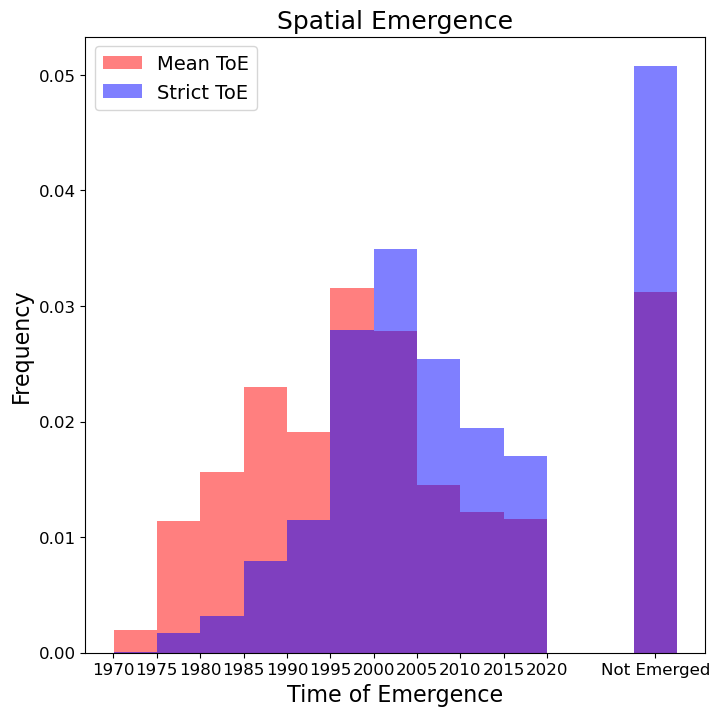

In [140]:
# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'strict' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

# data = regional_data_latloned
data = spatial_data

mean_data_subset = copy.copy(data.sel(metric='mean'))
strict_data_subset  = copy.copy(data.sel(metric='strict'))

mean_data_subset = xr.where(np.isnan(mean_data_subset),2032,mean_data_subset)
strict_data_subset = xr.where(np.isnan(strict_data_subset),2032,strict_data_subset)

fig,ax = plt.subplots(1,1,figsize=(8,8))

bins = np.arange(1970.01,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.06,0.01)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack = mean_data_subset.stack(z=('lat','lon','model','obs')).values

ax.hist(x=mean_data_subset_stack,
         bins=bins,
         color='red',alpha=0.5,label='Mean ToE',
         density=True,
         weights=mean_data_weights_stack,
        )

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack = strict_data_subset.stack(z=('lat','lon','model','obs')).values

ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict ToE',
         density=True,
         weights=strict_data_weights_stack,
        )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Frequency',fontsize=16)

ax.set_title('Spatial Emergence',fontsize=18)
ax.legend(fontsize=14)

In [50]:
model  = 'CESM1'
obs    = 'GISTEMP_5x5'
metric = 'mean' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = regional_data.sel(model=model,obs=obs,metric=metric)
spatial_data_subset  = spatial_data.sel(model=model,obs=obs,metric=metric)

toe_levels = np.arange(1970,2021,5)

for _levelstart,_levelstop in zip(toe_levels[:-1],toe_levels[1:]): # iterate over bounds
    
    # print(_levelstart,_levelstop)
    
    # count = 
    pass

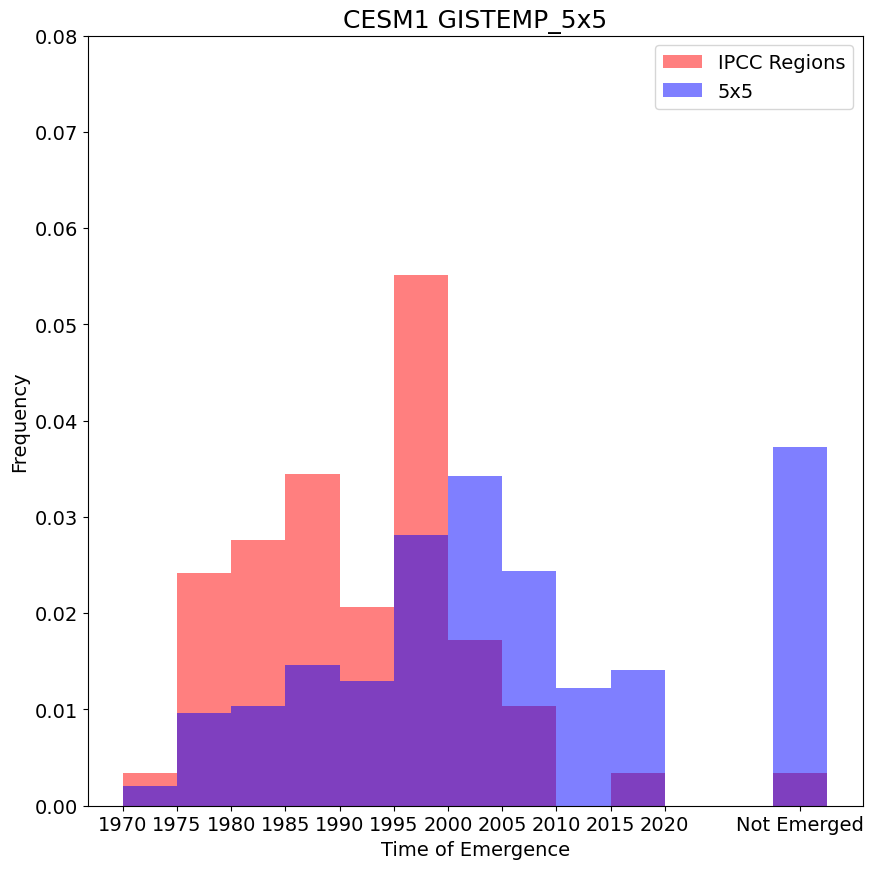

In [22]:
model  = 'CESM1'
obs    = 'GISTEMP_5x5'
metric = 'mean' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(model=model,obs=obs,metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(model=model,obs=obs,metric=metric))

regional_data_subset = xr.where(np.isnan(regional_data_subset),2032,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),2032,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970.01,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.09,0.01)

regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('%s %s' % (model,obs),fontsize=18)
ax.legend(fontsize=14)

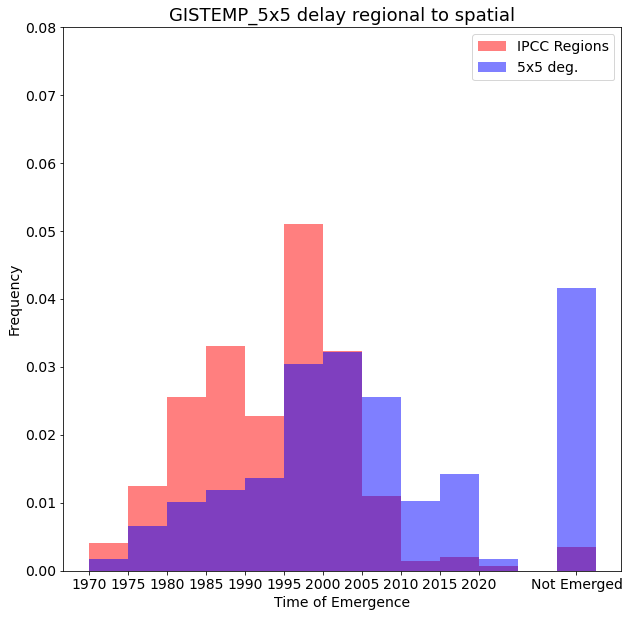

In [105]:

# Go model agnostic

model  = 'CESM1'
obs    = 'GISTEMP_5x5'
metric = 'mean' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(obs=obs,metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(obs=obs,metric=metric))

regional_data_subset = xr.where(np.isnan(regional_data_subset),2032,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),2032,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.09,0.01)

regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5 deg.',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('%s delay regional to spatial' % (obs),fontsize=18)
ax.legend(fontsize=14)

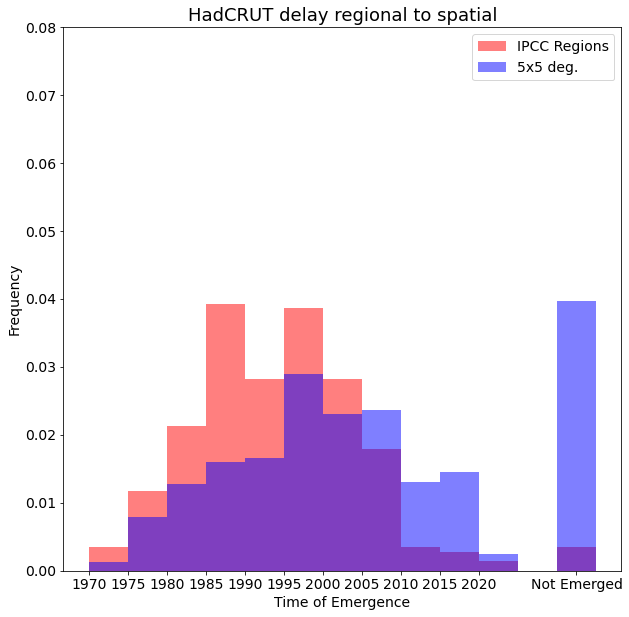

In [106]:

# Go model agnostic

model  = 'CESM1'
obs    = 'HadCRUT'
metric = 'mean' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(obs=obs,metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(obs=obs,metric=metric))

regional_data_subset = xr.where(np.isnan(regional_data_subset),2032,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),2032,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.09,0.01)

regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5 deg.',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('%s delay regional to spatial' % (obs),fontsize=18)
ax.legend(fontsize=14)

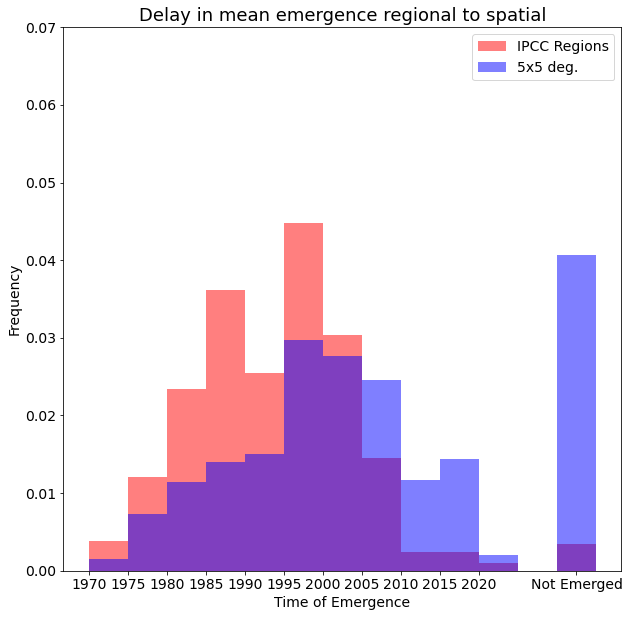

In [111]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'mean' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

regional_data_subset = xr.where(np.isnan(regional_data_subset),2032,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),2032,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.07,0.01)

regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5 deg.',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('Delay in %s emergence regional to spatial' % (metric),fontsize=18)
ax.legend(fontsize=14)

Cool, this shows the delay due to the method spatial averaging!

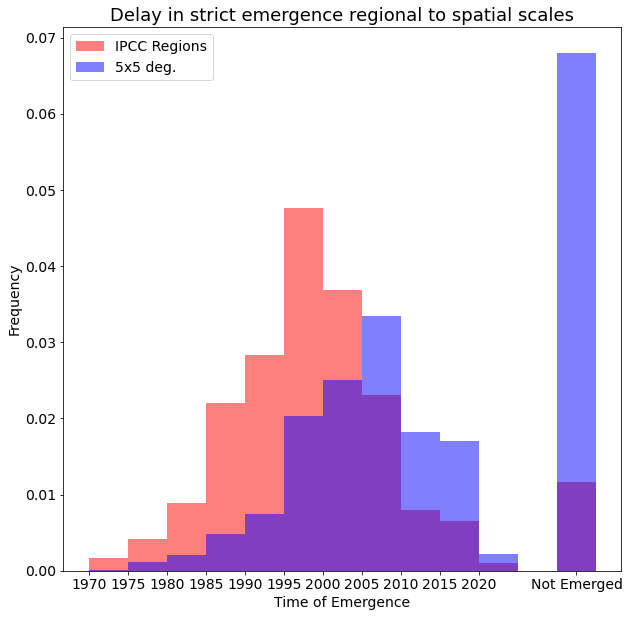

In [122]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'strict' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

regional_data_subset = xr.where(np.isnan(regional_data_subset),2032,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),2032,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.07,0.01)

regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5 deg.',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('Delay in %s emergence regional to spatial scales' % (metric),fontsize=18)
ax.legend(fontsize=14)

Cool, this shows the delay due to the method spatial averaging!

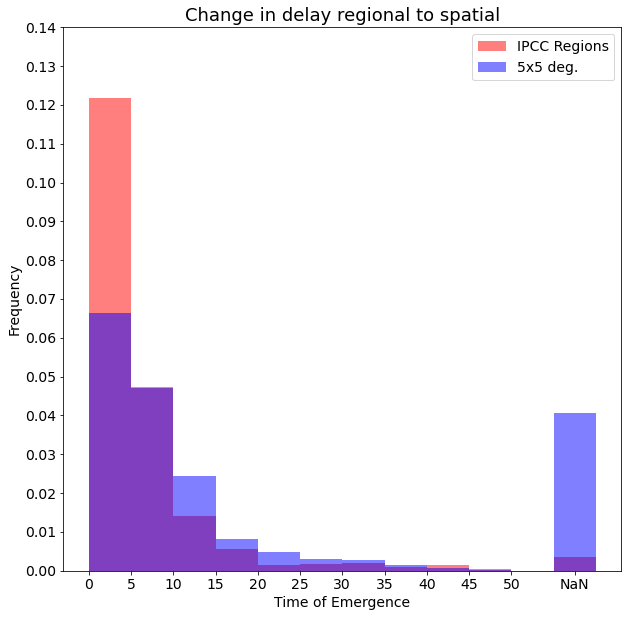

In [121]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'delay' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = copy.copy(regional_data.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

nan_mask_value = 57.5
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(0,61,5)
xticks = list(np.arange(0,51,5))
xticks.append(57.5)
xticklabels = list(np.arange(0,51,5))
xticklabels.append('NaN')
yticks = np.arange(0,0.14,0.01)

# yticks = np.arange(0,0.07,0.01)


regional_data_subset.plot.hist(ax=ax,
                               xticks=xticks,yticks=yticks,
                               bins=bins,
                               color='red',alpha=0.5,label='IPCC Regions',
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=xticks,yticks=yticks,
                              bins=bins,
                              color='blue',alpha=0.5,label='5x5 deg.',
                              density=True,
                             )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('Change in %s regional to spatial' % (metric),fontsize=18)
ax.legend(fontsize=14)

This shows that delays get longer when we change scales too!

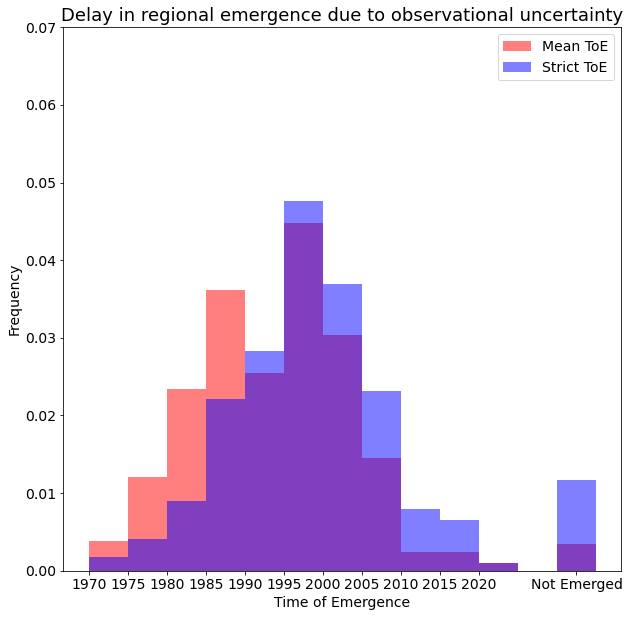

In [127]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'strict' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

mean_data_subset = copy.copy(regional_data.sel(metric='mean'))
strict_data_subset  = copy.copy(regional_data.sel(metric='strict'))

mean_data_subset = xr.where(np.isnan(mean_data_subset),2032,mean_data_subset)
strict_data_subset = xr.where(np.isnan(strict_data_subset),2032,strict_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.07,0.01)

mean_data_subset.plot.hist(ax=ax,
                           xticks=xticks,yticks=yticks,
                           bins=bins,
                           color='red',alpha=0.5,label='Mean ToE',
                           density=True,
                           weights=None,
                          )

strict_data_subset.plot.hist(ax=ax,
                             xticks=xticks,yticks=yticks,
                             bins=bins,
                             color='blue',alpha=0.5,label='Strict ToE',
                             density=True,
                             weights=None,
                            )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('Delay in regional emergence due to observational uncertainty',fontsize=18)
ax.legend(fontsize=14)

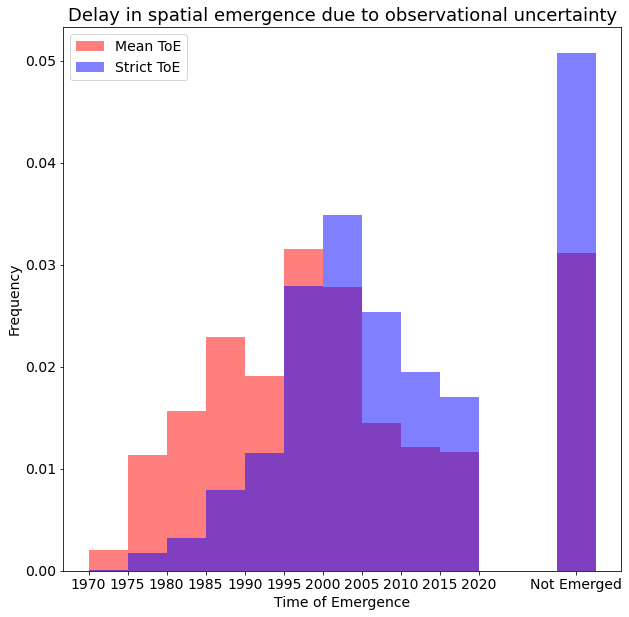

In [163]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'strict' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

mean_data_subset = copy.copy(spatial_data.sel(metric='mean'))
strict_data_subset  = copy.copy(spatial_data.sel(metric='strict'))

mean_data_subset = xr.where(np.isnan(mean_data_subset),2032,mean_data_subset)
strict_data_subset = xr.where(np.isnan(strict_data_subset),2032,strict_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970.01,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.06,0.01)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack = mean_data_subset.stack(z=('lat','lon','model','obs')).values

ax.hist(x=mean_data_subset_stack,
         bins=bins,
         color='red',alpha=0.5,label='Mean ToE',
         density=True,
         weights=mean_data_weights_stack,
        )

# mean_data_subset_stack.plot.hist(ax=ax,
#                            xticks=xticks,yticks=yticks,
#                            bins=bins,
#                            color='red',alpha=0.5,label='Mean ToE',
#                            density=True,
#                            weights=mean_data_weights_stack,
#                           )

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack = strict_data_subset.stack(z=('lat','lon','model','obs')).values

# strict_data_subset_stack.plot.hist(ax=ax,
#                              xticks=xticks,yticks=yticks,
#                              bins=bins,
#                              color='blue',alpha=0.5,label='Strict ToE',
#                              density=True,
#                              weights=strict_data_weights_stack,
#                             )

ax.hist(x=strict_data_subset_stack,
         bins=bins,
         color='blue',alpha=0.5,label='Strict ToE',
         density=True,
         weights=strict_data_weights_stack,
        )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=14)

ax.set_yticks(yticks)
ax.set_ylabel('Frequency',fontsize=14)

ax.set_title('Delay in spatial emergence due to observational uncertainty',fontsize=18)
ax.legend(fontsize=14)

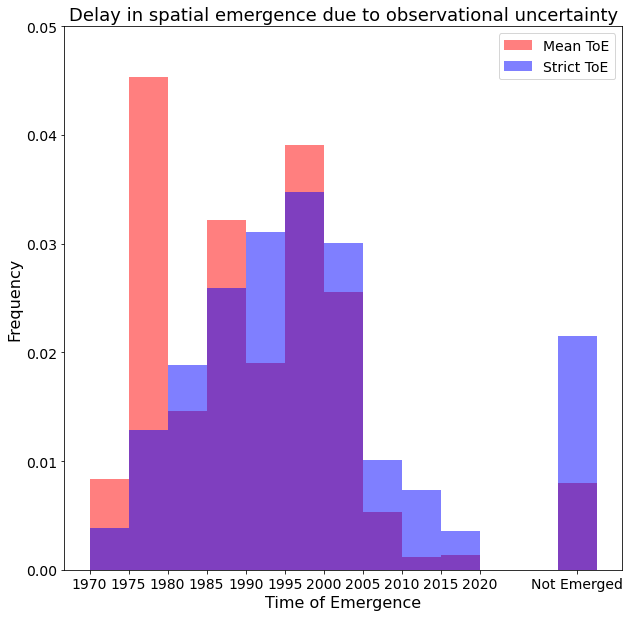

In [172]:

# Go model agnostic

# model  = 'CESM1'
# obs    = 'HadCRUT'
metric = 'strict' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da
spatial_data  = spatial_masked_da

data = regional_data_latloned

mean_data_subset = copy.copy(data.sel(metric='mean'))
strict_data_subset  = copy.copy(data.sel(metric='strict'))

mean_data_subset = xr.where(np.isnan(mean_data_subset),2032,mean_data_subset)
strict_data_subset = xr.where(np.isnan(strict_data_subset),2032,strict_data_subset)

fig,ax = plt.subplots(1,1,figsize=(10,10))

bins = np.arange(1970.01,2036,5)
xticks = np.arange(1970,2036,5)
xticks = list(np.arange(1970,2021,5))
xticks.append(2032.5)
xticklabels = list(np.arange(1970,2021,5))
xticklabels.append('Not Emerged')
yticks = np.arange(0,0.06,0.01)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=('lat','lon','model','obs')).values
mean_data_subset_stack = mean_data_subset.stack(z=('lat','lon','model','obs')).values

ax.hist(x=mean_data_subset_stack,
         # xticks=xticks,yticks=yticks,
         bins=bins,
         color='red',alpha=0.5,label='Mean ToE',
         density=True,
         weights=mean_data_weights_stack,
        )

# mean_data_subset_stack.plot.hist(ax=ax,
#                            xticks=xticks,yticks=yticks,
#                            bins=bins,
#                            color='red',alpha=0.5,label='Mean ToE',
#                            density=True,
#                            weights=mean_data_weights_stack,
#                           )

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=('lat','lon','model','obs')).values
strict_data_subset_stack = strict_data_subset.stack(z=('lat','lon','model','obs')).values

# strict_data_subset_stack.plot.hist(ax=ax,
#                              xticks=xticks,yticks=yticks,
#                              bins=bins,
#                              color='blue',alpha=0.5,label='Strict ToE',
#                              density=True,
#                              weights=strict_data_weights_stack,
#                             )

ax.hist(x=strict_data_subset_stack,
         # xticks=xticks,yticks=yticks,
         bins=bins,
         color='blue',alpha=0.5,label='Strict ToE',
         density=True,
         weights=strict_data_weights_stack,
        )

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Frequency',fontsize=16)

ax.set_title('Delay in spatial emergence due to observational uncertainty',fontsize=18)
ax.legend(fontsize=14)

In [143]:
strict_data_subset.stack(z=('lat','lon','model','obs'))

<xarray.DataArray 'duration' (z: 25920)>
array([2032., 2032., 2032., ..., 2006., 2002., 2006.])
Coordinates:
    metric   <U6 'strict'
  * z        (z) MultiIndex
  - lat      (z) float64 -87.5 -87.5 -87.5 -87.5 -87.5 ... 87.5 87.5 87.5 87.5
  - lon      (z) float64 -177.5 -177.5 -177.5 -177.5 ... 177.5 177.5 177.5 177.5
  - model    (z) object 'CESM1' 'CESM1' 'MPI' ... 'ESM2M' 'OBS-LE' 'OBS-LE'
  - obs      (z) object 'GISTEMP_5x5' 'HadCRUT' ... 'GISTEMP_5x5' 'HadCRUT'

In [137]:
weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)

In [140]:
out[1]

<xarray.DataArray 'duration' (lat: 36, lon: 72, model: 5, obs: 2)>
array([[[[2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.]],

        [[2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.]],

        [[2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.],
         [2032., 2032.]],

        ...,

...

        ...,

        [[2006., 2008.],
         [2003., 2006.],
         [2006., 2008.],
         [2002., 2006.],
         [2003., 2006.]],

        [[2006., 2008.],
         [2002., 2006.],
         [2006., 2008.],
         [2002., 2006.],
         [2002., 2006.]],

        [[2005., 2008.],
         [2002., 2006.],
         [2006., 2008.],
         [2002., 2006.],
         [2002., 2006.]]]])
Coordinates:
    metric   <U6 'strict'
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * model    (model) object 'CESM1' 'MPI' 'CanESM2' 'ESM2M' 'OBS-LE'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * obs      (obs) object 'GISTEMP_5x5' 'HadCRUT'

In [134]:
np.cos(np.deg2rad(strict_data_subset.lat))

<xarray.DataArray 'lat' (lat: 36)>
array([0.04361939, 0.13052619, 0.21643961, 0.3007058 , 0.38268343,
       0.46174861, 0.53729961, 0.60876143, 0.67559021, 0.73727734,
       0.79335334, 0.84339145, 0.88701083, 0.92387953, 0.95371695,
       0.97629601, 0.99144486, 0.99904822, 0.99904822, 0.99144486,
       0.97629601, 0.95371695, 0.92387953, 0.88701083, 0.84339145,
       0.79335334, 0.73727734, 0.67559021, 0.60876143, 0.53729961,
       0.46174861, 0.38268343, 0.3007058 , 0.21643961, 0.13052619,
       0.04361939])
Coordinates:
    metric   <U6 'strict'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5

<xarray.DataArray 'duration' (lat: 36, lon: 72, model: 5, obs: 2)>
array([[[[2007., 2009.],
         [2008., 2010.],
         [2008., 2011.],
         [2032., 2032.],
         [2007., 2008.]],

        [[2008., 2010.],
         [2008., 2010.],
         [2008., 2011.],
         [2032., 2032.],
         [2007., 2007.]],

        [[2007., 2009.],
         [2008., 2010.],
         [2008., 2011.],
         [2032., 2032.],
         [2007., 2007.]],

        ...,

...

        ...,

        [[2001., 2005.],
         [1998., 1998.],
         [2001., 2005.],
         [1996., 1997.],
         [1998., 1998.]],

        [[2001., 2005.],
         [1998., 1998.],
         [2001., 2005.],
         [1996., 1997.],
         [1998., 1998.]],

        [[2001., 2005.],
         [1998., 1998.],
         [2000., 2005.],
         [1996., 1997.],
         [1998., 1998.]]]])
Coordinates:
    metric   <U4 'mean'
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * model    (model) object 'CESM1' 'MPI' 'CanESM2' 'ESM2M' 'OBS-LE'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * obs      (obs) object 'GISTEMP_5x5' 'HadCRUT'

In [131]:
np.cos(np.deg2rad(mean_data_subset.lat))

<xarray.DataArray 'lat' (lat: 36)>
array([0.04361939, 0.13052619, 0.21643961, 0.3007058 , 0.38268343,
       0.46174861, 0.53729961, 0.60876143, 0.67559021, 0.73727734,
       0.79335334, 0.84339145, 0.88701083, 0.92387953, 0.95371695,
       0.97629601, 0.99144486, 0.99904822, 0.99904822, 0.99144486,
       0.97629601, 0.95371695, 0.92387953, 0.88701083, 0.84339145,
       0.79335334, 0.73727734, 0.67559021, 0.60876143, 0.53729961,
       0.46174861, 0.38268343, 0.3007058 , 0.21643961, 0.13052619,
       0.04361939])
Coordinates:
    metric   <U4 'mean'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5

In [130]:
mean_data_subset.lat

<xarray.DataArray 'lat' (lat: 36)>
array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5, -42.5,
       -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,
        12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,  47.5,  52.5,  57.5,
        62.5,  67.5,  72.5,  77.5,  82.5,  87.5])
Coordinates:
    metric   <U4 'mean'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5

Wow, there is a big shift in ToE when we look at the spatial trends!

Strict emergence is later, but this doesn't make it seem by much.

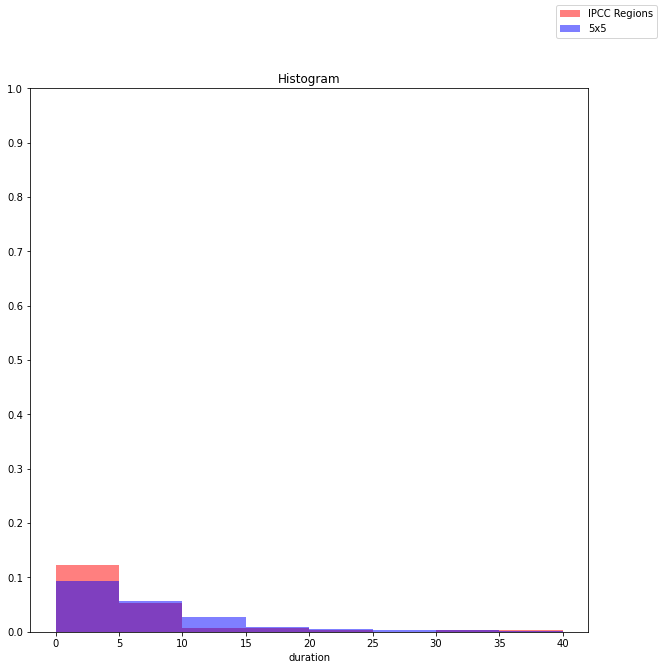

In [63]:
model  = 'CESM1'
obs    = 'GISTEMP_5x5'
metric = 'delay' # 'strict' 'mean'

regional_data = regional_box[0] # regional data not applied to a lat-lon grid
spatial_data  = spatial_masked_da

regional_data_subset = regional_data.sel(model=model,obs=obs,metric=metric)
spatial_data_subset  = spatial_data.sel(model=model,obs=obs,metric=metric)

fig,ax = plt.subplots(1,1,figsize=(10,10))

regional_data_subset.plot.hist(ax=ax,
                               xticks=np.arange(0,41,5),yticks=np.arange(0,1.1,0.1),
                               # xticklabels=['hi','2'],
                               bins=np.arange(0,41,5),
                               color='red',alpha=0.5,label='IPCC Regions',
                               # normed=1,
                               density=True,
                              )

spatial_data_subset.plot.hist(ax=ax,
                              xticks=np.arange(0,41,5),yticks=np.arange(0,1.1,0.1),
                              bins=np.arange(0,41,5),
                              color='blue',alpha=0.5,label='5x5',
                              # normed=1,
                               density=True,
                             )

fig.legend()

In [30]:
spatial_masked_da

<xarray.DataArray 'duration' (lat: 36, lon: 72, metric: 4, model: 5, obs: 2)>
array([[[[[2.007e+03, 2.009e+03],
          [2.008e+03, 2.010e+03],
          [2.008e+03, 2.011e+03],
          [      nan,       nan],
          [2.007e+03, 2.008e+03]],

         [[      nan,       nan],
          [      nan,       nan],
          [      nan,       nan],
          [      nan,       nan],
          [      nan,       nan]],

         [[1.300e+01, 1.100e+01],
          [1.200e+01, 1.000e+01],
          [1.200e+01, 9.000e+00],
          [      nan,       nan],
          [1.300e+01, 1.200e+01]],

         [[1.000e+00, 1.000e+00],
          [1.000e+00, 1.000e+00],
...
          [1.996e+03, 1.997e+03],
          [1.998e+03, 1.998e+03]],

         [[2.005e+03, 2.008e+03],
          [2.002e+03, 2.006e+03],
          [2.006e+03, 2.008e+03],
          [2.002e+03, 2.006e+03],
          [2.002e+03, 2.006e+03]],

         [[4.000e+00, 3.000e+00],
          [4.000e+00, 8.000e+00],
          [6.000e+00, 3.000e+00],
          [6.000e+00, 9.000e+00],
          [4.000e+00, 8.000e+00]],

         [[0.000e+00, 0.000e+00],
          [0.000e+00, 0.000e+00],
          [0.000e+00, 0.000e+00],
          [0.000e+00, 0.000e+00],
          [0.000e+00, 0.000e+00]]]]])
Coordinates:
  * metric   (metric) object 'mean' 'strict' 'delay' 'delay_mask'
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * model    (model) object 'CESM1' 'MPI' 'CanESM2' 'ESM2M' 'OBS-LE'
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * obs      (obs) object 'GISTEMP_5x5' 'HadCRUT'